## Introduction

This notebook calculates pluri-annual trends of groundwater levels in each aquifer. 

It takes in input:

    - A set of CSV files containing the water level monitoring data. Each CSV file corresponds to an individual aquifer. 

It creates in output:

    - A set of PNG files containing the charts of the water level trends (one aquifer per PNG file).
    
    - A CSV summary file containing the list of aquifers and for each aquifer: the number of observation wells used to calculate the trend, the slope of the trend, whether the trend is stable/rising or declining, etc. This CSV file can be completed with the area of the aquifers.
    

In [7]:
import numpy as np
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import warnings; warnings.filterwarnings(action='ignore')

# 1. Open input files one by one
This loop will open one input file after the other. See https://stackoverflow.com/questions/18262293/how-to-open-every-file-in-a-folder

In [8]:
#import os, glob
#path = '/some/path/to/file'
#for filename in glob.glob(os.path.join(path, '*.csv')):   # only input files must be in csv format!


# 2. Read groundwater level time series

The time series are in a .csv table in the form of: Observation point - Date - Groundwater Level

site / date / level

The title of csv files is the name of the aquifer. For example "Aquifer_X.csv"

In [22]:
#Groundwater level time series are in the file WATERLEVEL_demo, read into gdf dataframe
filename = "WATERLEVEL_MOD.csv"
gdf = pd.DataFrame(pd.read_csv(filename, index_col='date', parse_dates=True, infer_datetime_format=True)) #replace demo file with filename
gdf.head()

,site,level
date,,
2000-12-04,#430010099580601,10.57656
2000-10-05,#430010099580601,10.57656
2000-06-28,#430010099580601,10.72896
2000-08-18,#430010099580601,10.97280
2000-02-11,#430010099580601,11.09472


There are some cases where borehole names are numbers (as is the case for most boreholes in the US). When they are read into the notebook, they usually have a scientific format. If this happens, sometimes the value is modified. To avoid that, append a   #  symbol in front of each site name in the .csv file.

Now we create a matrix table with one time series per column. We resample this new dataframe to a monthly timescale and create a list of the column names.

In [23]:
#gdf_pivot is new matrix table/dataframe
gdf_pivot = gdf.pivot_table(index='date',columns='site',values='level')
gdf_pivot = gdf_pivot.resample('1m').mean()
keys_gdf = list(gdf.site.unique()) #list of unique values of long time series
gdf_pivot.head()

site,#10,#1004901,#1051909,#1053602,#11,#1142315,#1151403,#1204452,#1211118,#13,...,#61,#635912,#655504,#7,#712401,#8,#9,#9074,#9202,#9708
date,,,,,,,,,,,,,,,,,,,,,
2000-01-31,19.729704,NaN,41.340024,34.349436,NaN,NaN,54.848760,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,68.122800,NaN,NaN,NaN,NaN,NaN
2000-02-29,NaN,NaN,NaN,34.397442,NaN,NaN,NaN,NaN,NaN,NaN,...,28.431744,NaN,NaN,NaN,68.056506,NaN,NaN,NaN,NaN,NaN
2000-03-31,NaN,NaN,NaN,34.440114,NaN,NaN,NaN,NaN,NaN,NaN,...,28.736544,NaN,NaN,NaN,68.023740,NaN,NaN,NaN,NaN,NaN
2000-04-30,NaN,NaN,NaN,34.493200,NaN,NaN,NaN,NaN,NaN,NaN,...,28.474416,NaN,NaN,NaN,68.019930,NaN,NaN,NaN,NaN,NaN
2000-05-31,NaN,NaN,NaN,34.610040,NaN,55.632096,55.201718,NaN,NaN,NaN,...,28.852368,NaN,NaN,NaN,68.143374,NaN,NaN,NaN,NaN,NaN


## 2. Select period to be used in the evaluation

We are interested in the trends over the last 10 years, from 01-01-2013 to 31/12/2022. In principle the data in input should be within this period, but we resample the data to be sure they are. 

In [24]:
#Select period in "gdf_pivot_1".
gdf_pivot_1 = gdf_pivot.copy()['01-01-2013':'31-12-2022']
gdf_pivot_1.head()

site,#10,#1004901,#1051909,#1053602,#11,#1142315,#1151403,#1204452,#1211118,#13,...,#61,#635912,#655504,#7,#712401,#8,#9,#9074,#9202,#9708
date,,,,,,,,,,,,,,,,,,,,,
2013-01-31,18.925524,68.367783,45.253656,43.502072,1.283503,57.318402,64.121538,40.520112,31.553658,4.964012,...,32.355110,105.589578,108.768642,3.650285,75.036680,4.361078,18.009108,NaN,NaN,NaN
2013-02-28,18.906200,68.346066,45.101256,43.478958,1.253817,57.329070,64.116966,40.317725,31.571946,4.992515,...,32.331987,105.718051,108.642912,3.669566,74.958702,4.345432,18.000472,NaN,NaN,NaN
2013-03-31,18.894060,68.312538,45.047916,43.529707,1.220675,57.335166,64.046100,40.339518,31.610808,4.975811,...,32.277042,105.723690,108.532574,3.668268,74.920602,4.310177,17.997932,NaN,NaN,NaN
2013-04-30,18.883986,68.343780,45.212508,43.581828,1.122070,57.355435,63.794640,41.593008,31.610046,4.942332,...,32.229552,105.715308,108.847890,3.633426,74.839068,4.311133,18.004536,NaN,NaN,NaN
2013-05-31,18.880197,68.523231,45.204507,43.690032,1.037303,57.374218,64.196214,43.444859,31.650813,5.118084,...,32.200449,105.800461,108.899896,3.617874,75.152359,4.307129,18.003012,NaN,NaN,NaN


<AxesSubplot:xlabel='date'>

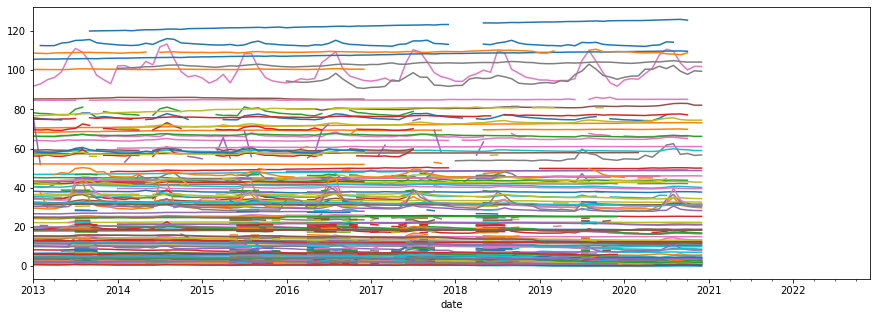

In [25]:
#First glance of the data
gdf_pivot_1.plot(figsize=(15,5), legend=False, xlim=[datetime.date(2013, 1, 1), datetime.date(2022, 12, 31)])

## 3. Data filtering
This is a facultative step to remove some observation wells from the analysis, for instance if they are incomplete. 

The number of columns/boreholes with a complete data set is  56


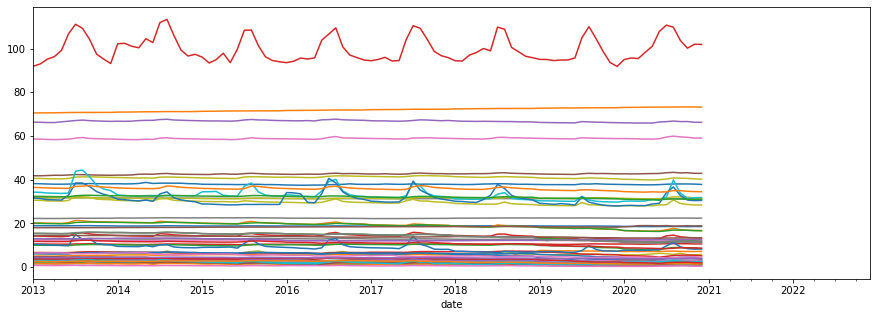

In [26]:
# drop sites with any missing value
gdf_1 = gdf_pivot_1.copy().dropna(axis=1) #THERE IS AN ISSUE HERE, DATA SHOULD SPAN OVER THE ENTIRE TIMESPAN

# drop sites with more missing values than a given threshold - to be finalized
# gdf_1 = gdf_pivot_1.copy().XXXXXXXX 

gdf_1.plot(figsize=(15,5), legend=None, xlim=[datetime.date(2013, 1, 1), datetime.date(2022, 12, 31)])
print("The number of columns/boreholes with a complete data set is ", gdf_1.shape[1]) 

In [27]:
#Final dataset to work further in the evaluation
gdf_1

site,#10,#13,#14,#18,#20,#22,#23,#25,#26,#27,...,#46,#49,#57,#58,#59,#60,#61,#7,#8,#9
date,,,,,,,,,,,,,,,,,,,,,
2013-01-31,18.925524,4.964012,3.265627,10.544605,3.855130,3.543349,12.343810,22.232800,2.385797,2.273611,...,0.697205,15.383256,31.649822,34.284691,31.588489,36.444739,32.355110,3.650285,4.361078,18.009108
2013-02-28,18.906200,4.992515,3.265018,10.519845,3.885003,3.547763,12.344291,22.221988,2.367643,2.269236,...,0.675241,15.414933,31.647384,34.187565,31.324623,36.326391,32.331987,3.669566,4.345432,18.000472
2013-03-31,18.894060,4.975811,3.265627,10.494756,3.818357,3.553476,12.355215,22.207728,2.344994,2.265254,...,0.652370,15.365558,31.522416,33.864853,30.824129,36.223907,32.277042,3.668268,4.310177,17.997932
2013-04-30,18.883986,4.942332,3.264408,10.468864,3.819550,3.547770,12.363907,22.196552,2.294128,2.256638,...,0.644042,15.340990,31.664453,33.778647,30.753231,36.104373,32.229552,3.633426,4.311133,18.004536
2013-05-31,18.880197,5.118084,3.264408,10.445693,3.840775,3.489173,12.374192,22.217069,2.278331,2.245688,...,0.653943,15.270480,31.672987,33.691609,30.628270,36.010350,32.200449,3.617874,4.307129,18.003012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,18.554122,7.258444,2.941320,10.671784,2.393100,2.851667,11.971808,22.394812,1.480802,0.967372,...,0.451735,11.720401,32.085981,39.834417,36.668701,34.972542,31.180409,2.134966,3.791502,18.715666
2020-09-30,18.528465,7.153221,2.980291,10.666694,2.471166,2.889395,11.970149,22.405739,1.467721,0.988749,...,0.480060,11.936403,32.061803,33.786862,32.739439,34.947933,31.111045,2.186940,3.817402,18.805725
2020-10-31,18.477562,7.111097,2.977219,10.631311,2.521062,2.903403,11.966682,22.402256,1.426137,0.995993,...,0.462475,11.959562,32.009364,31.401367,30.662445,34.662559,31.034502,2.221992,3.832508,18.886497


## 4. Calculate aquifer-average trend
See https://www.w3schools.com/python/matplotlib_subplot.asp

In [38]:
# dataframe with aquifer / site / date / level
gdf_melt = gdf_1.copy() #dataframe from step 3
gdf_melt = gdf_melt.unstack().reset_index(name='level')
gdf_melt.set_index('site', inplace=True)
gdf_melt

,date,level
site,,
#10,2013-01-31,18.925524
#10,2013-02-28,18.906200
#10,2013-03-31,18.894060
#10,2013-04-30,18.883986
#10,2013-05-31,18.880197
...,...,...
#9,2020-08-31,18.715666
#9,2020-09-30,18.805725
#9,2020-10-31,18.886497


In [39]:
#OBTAIN MEAN WATER LEVEL PER SITE TO THEN SUBTRACT FROM WATER LEVELS - ANOMALY 
waterlevel_means = gdf_melt.reset_index().groupby('site', as_index=False)['level'].mean()
waterlevel_means.set_index('site', inplace=True)
waterlevel_means

,level
site,
#10,18.772794
#13,5.992357
#14,2.936063
#18,10.463679
#20,3.235414
#22,3.038835
#23,12.152335
#25,22.372000
#26,1.684103


In [40]:
# ASSIGN MEAN WATER LEVEL TO EACH DATA ROW
gdf_melt['mean_level'] = gdf_melt.index.map(waterlevel_means['level'])
gdf_melt

,date,level,mean_level
site,,,
#10,2013-01-31,18.925524,18.772794
#10,2013-02-28,18.906200,18.772794
#10,2013-03-31,18.894060,18.772794
#10,2013-04-30,18.883986,18.772794
#10,2013-05-31,18.880197,18.772794
...,...,...,...
#9,2020-08-31,18.715666,18.356832
#9,2020-09-30,18.805725,18.356832
#9,2020-10-31,18.886497,18.356832


In [42]:
# Calculate normalized water level "norm_level"
#longdf_noindex = long_df_melt.copy()
#longdf_noindex.reset_index(inplace=True)

gdf_melt['norm_level'] = gdf_melt['level'] - gdf_melt['mean_level']
gdf_melt      
#longdf_noindex
        

,date,level,mean_level,norm_level
site,,,,
#10,2013-01-31,18.925524,18.772794,0.152729
#10,2013-02-28,18.906200,18.772794,0.133405
#10,2013-03-31,18.894060,18.772794,0.121266
#10,2013-04-30,18.883986,18.772794,0.111191
#10,2013-05-31,18.880197,18.772794,0.107402
...,...,...,...,...
#9,2020-08-31,18.715666,18.356832,0.358833
#9,2020-09-30,18.805725,18.356832,0.448892
#9,2020-10-31,18.886497,18.356832,0.529664


-1.2169757874888045
17.718907254975786


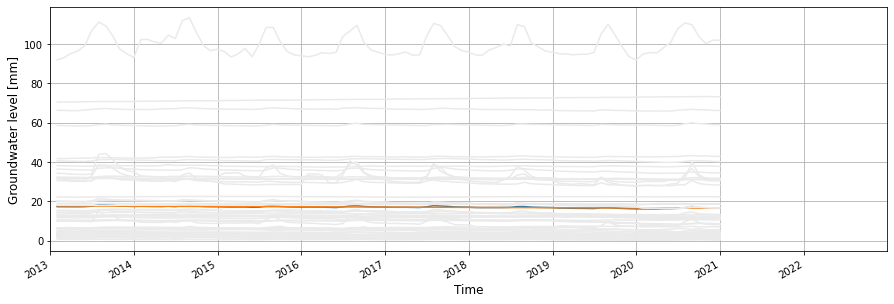

In [43]:
# aquifer-averaged data
final_df1 = gdf_melt[['date', 'level']].groupby('date', as_index=False).mean()

# linear trend
final_df1.loc[:, "date"] = pd.to_datetime(final_df1.loc[:, "date"], format="%d-%b-%y")
y_values = final_df1.loc[:, "level"]
x_values = np.linspace(0,1,len(final_df1.loc[:, "level"]))
slope,b = np.polyfit(x_values,y_values, 1)
print(slope)
print(b)
linear_fit = x_values*slope + b


fig, ax = plt.subplots(figsize=(15,5))

plt.plot(final_df1.loc[:, "date"],final_df1.loc[:, "level"]) # the composite hydrograph
plt.plot(final_df1.loc[:, "date"],linear_fit)                # the linear regression
gdf_1.plot(ax = ax, legend=None, color='#EAEAEA')                 # all the monitoring curves

# axes
ax.set_xlabel('Time', fontsize = 12)
ax.set_ylabel('Groundwater level [mm]', fontsize = 12)
ax.grid()
plt.xlim([datetime.date(2013, 1, 1), datetime.date(2022, 12, 31)])

# save chart as an image
fig.savefig("myplot.jpg", bbox_inches='tight')

plt.show()

#final_df1.set_index('date', inplace=True)
#final_df1

## 6. Update summary file

We save the information about this aquifer in the summary file